In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load data
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv"


Mounted at /content/drive


In [51]:
df= pd.read_csv(path)

In [129]:
df_X=df.query("Location == 'North America'")

#df_X=df_X.drop(['total deaths per million','new cases per million','new vaccinations smoothed','hosp patients per million','weekly icu admissions','total cases per million','Total deaths','New cases smoothed','Continent','Location','Total Cases','New Cases','New deaths','reproduction rate','new tests','total tests','total boosters','total vaccinations','hosp patients','icu patients','positive rate','people vaccinated','people fully vaccinated','total boosters','population','population density','median age','cardiovasc death rate','diabetes prevalence','female smokers','male smokers','aged 65 older','aged 70 older','extreme poverty','life expectancy'],axis=1)
df_X.drop(df_X.iloc[:, 9:52], inplace=True, axis=1)
df_X.drop(df_X.iloc[:, 3:8], inplace=True, axis=1)
df_X.drop(df.columns[[0, 1]], axis=1, inplace=True)
df_X

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Date,new deaths smoothed
111310,2020-01-22,0.000
111311,2020-01-23,0.000
111312,2020-01-24,0.000
111313,2020-01-25,0.000
111314,2020-01-26,0.000
...,...,...
112079,2022-03-01,2348.286
112080,2022-03-02,2067.429
112081,2022-03-03,1881.000
112082,2022-03-04,1836.000


In [127]:
df_X

,new deaths smoothed
Date,
2020-01-22,0.000
2020-01-23,0.000
2020-01-24,0.000
2020-01-25,0.000
2020-01-26,0.000
...,...
2022-02-27,2196.857
2022-02-28,2375.000
2022-03-01,2348.286


In [130]:
df_X.columns=["Date","new deaths smoothed"]
df_X["Date"] = pd.to_datetime(df_X["Date"])

df_X=df_X.set_index("Date")

<ipython-input-130-f1c3b9a8ddef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X["Date"] = pd.to_datetime(df_X["Date"])


In [131]:
#df_X=df_X[['Location','Total Cases','New Cases','New deaths','reproduction rate','new tests','total tests','total boosters','total vaccinations','hosp patients','icu patients','positive rate','people vaccinated','people fully vaccinated','total boosters','population','population density','median age','cardiovasc death rate','diabetes prevalence','female smokers','male smokers','aged 65 older','aged 70 older','extreme poverty','life expectancy']]
#df_X

df_train = df_X.iloc[:-480]
X=df_train
X

,new deaths smoothed
Date,
2020-01-22,0.000
2020-01-23,0.000
2020-01-24,0.000
2020-01-25,0.000
2020-01-26,0.000
...,...
2020-11-06,1558.571
2020-11-07,1589.286
2020-11-08,1612.143


Text(0.5, 1.0, 'New Deaths')

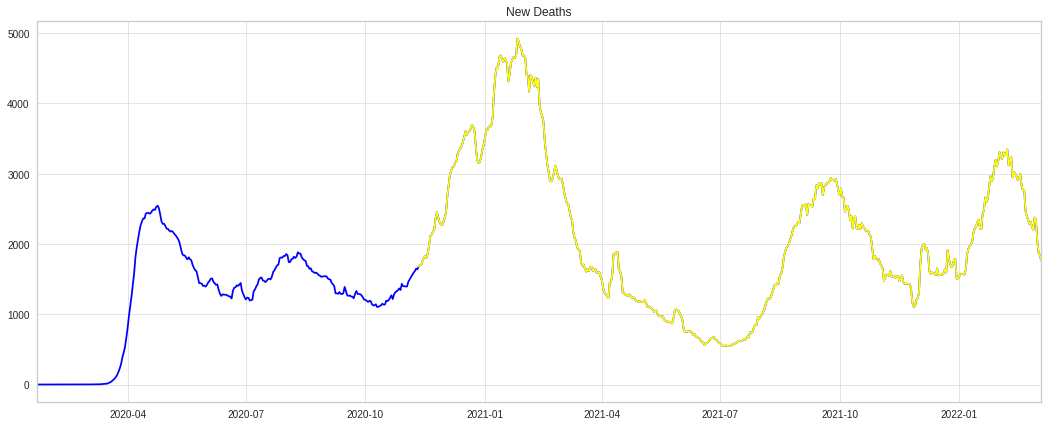

In [107]:
df_test = df_X.iloc[-480:]

plt.figure(figsize = (18,7))
plt.plot(df_X, label="Training data",color='blue')
plt.plot(df_test, label = "Test data",color='yellow')
plt.grid(alpha=0.5)
plt.margins(x=0)
plt.title("New Deaths")

In [108]:
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy


class RandomForestARModel():
    """
    Autoregressive forecasting with Random Forests
    """
    
    def __init__(self, n_lags=1, max_depth = 3, n_estimators=1000, random_state = 123,
                 log_transform = False, first_differences = False, seasonal_differences = None):
        """
        Args:
            n_lags: Number of lagged features to consider in autoregressive model
            max_depth: Max depth for the forest's regression trees
            random_state: Random state to pass to random forest
            
            log_transform: Whether the input should be log-transformed
            first_differences: Whether the input should be singly differenced
            seasonal_differences: Seasonality to consider, if 'None' then no seasonality is presumed
        """
        
        self.n_lags = n_lags
        self.model = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, random_state = random_state)
        
        self.log_transform = log_transform
        self.first_differences = first_differences
        self.seasonal_differences = seasonal_differences
        
        
        
    def fit(self, y):
        """
        Args:
            y: training data (numpy array or pandas series/dataframe)
        """
        #enable pandas functions via dataframes
        y_df = pd.DataFrame(y)
        self.y_df = deepcopy(y_df)
        
        #apply transformations and store results for retransformations
        if self.log_transform:
            y_df = np.log(y_df)
            self.y_logged = deepcopy(y_df)
        
        if self.first_differences:
            y_df = y_df.diff().dropna()
            self.y_diffed = deepcopy(y_df)
        
        if self.seasonal_differences is not None:
            y_df = y_df.diff(self.seasonal_differences).dropna()
            self.y_diffed_seasonal = deepcopy(y_df)
        
        
        #get lagged features
        Xtrain = pd.concat([y_df.shift(t) for t in range(1,self.n_lags+1)],axis=1).dropna()
        self.Xtrain = Xtrain
        
        ytrain = y_df.loc[Xtrain.index,:]
        self.ytrain = ytrain

        self.model.fit(Xtrain.values,ytrain.values.reshape(-1))

    
    
    def sample_forecast(self, n_periods = 1, n_samples = 10000, random_seed =123):
        """
        Draw forecasting samples by randomly drawing from all trees in the forest per forecast period
        Args:
            n_periods: Ammount of periods to forecast
            n_samples: Number of samples to draw
            random_seed: Random seed for numpy
        """
        samples = self._perform_forecast(n_periods, n_samples, random_seed)
        output = self._retransform_forecast(samples, n_periods)
        
        return output
    
    
    
    def _perform_forecast(self, n_periods, n_samples, random_seed):
        """
        Forecast transformed observations
        Args:
            n_periods: Ammount of periods to forecast
            n_samples: Number of samples to draw
            random_seed: Random seed for numpy
        """
        samples = []
        
        np.random.seed(random_seed)
        for i in range(n_samples):
            #store lagged features for each period
            Xf = np.concatenate([self.Xtrain.iloc[-1,1:].values.reshape(1,-1),
                                 self.ytrain.iloc[-1].values.reshape(1,1)],1)

            forecasts = []

            for t in range(n_periods):
                tree = self.model.estimators_[np.random.randint(len(self.model.estimators_))]
                pred = tree.predict(Xf)[0]
                forecasts.append(pred)
                
                #update lagged features for next period
                Xf = np.concatenate([Xf[:,1:],np.array([[pred]])],1)
            
            samples.append(forecasts)
        
        return samples
    
    
    
    def _retransform_forecast(self, samples, n_periods):
        """
        Retransform forecast (re-difference and exponentiate)
        Args:
            samples: Forecast samples for retransformation
            n_periods: Ammount of periods to forecast
        """
        
        full_sample_tree = []

        for samp in samples:
            draw = np.array(samp)
            
            #retransform seasonal differencing
            if self.seasonal_differences is not None:
                result = list(self.y_diffed.iloc[-self.seasonal_differences:].values)
                for t in range(n_periods):
                    result.append(result[t]+draw[t])
                result = result[self.seasonal_differences:]
            else:
                result = []
                for t in range(n_periods):
                    result.append(draw[t])
            
            #retransform first differences
            y_for_add = self.y_logged.values[-1] if self.log_transform else self.y_df.values[-1]
            
            if self.first_differences:
                result = y_for_add + np.cumsum(result)
            
            #retransform log transformation
            if self.log_transform:
                result = np.exp(result)
            
            full_sample_tree.append(result.reshape(-1,1))

        return np.concatenate(full_sample_tree,1)


In [170]:
model = RandomForestARModel(n_lags = 2, log_transform = True, first_differences = True, seasonal_differences = 12)
model.fit(df_train)

predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)


means_forest = np.mean(predictions_forest,1)
lowers_forest = np.quantile(predictions_forest,0.05,1)
uppers_forest = np.quantile(predictions_forest,0.95,1)

plt.figure(figsize = (18,7))

plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label = "Training observations (truncated)")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")

plt.plot(df_test.index,means_forest,color="purple", label = "RF mean forecast")

plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label = "RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

ValueError: ignored

In [122]:
df_X = df_X[:int(len(df_X)-1)]
#df_X = df_X.dropna()
#X = df_X.drop(['Continent','Location','Date','tests units','Total deaths'], axis=1)
#X = df_X.drop(['Location'], axis=1)
X

,new deaths smoothed
Date,
2020-01-22,0.000
2020-01-23,0.000
2020-01-24,0.000
2020-01-25,0.000
2020-01-26,0.000
...,...
2020-11-05,1526.857
2020-11-06,1558.571
2020-11-07,1589.286


In [124]:
#df_y=df.query("Location == 'Canada'")
#df_y = df_y.dropna()
#y= df_y.drop(['Continent','Location','Date','tests units'], axis=1)
#y
#X = np.random.rand(100, 5) # 100 samples, 5 features
y = df_X['new deaths smoothed'][:294]
#y = np.random.randint(0, 2, size=773) # binary target variable

In [133]:
#Splitting the dataset into train and testing
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(235, 1) (59, 1) (235,) (59,)


In [134]:
import sklearn
from sklearn.ensemble import RandomForestRegressor

In [135]:
model = RandomForestRegressor(n_estimators=100,random_state=42)

In [136]:
#fit the model
fit_model = model.fit(X_train, y_train)

In [137]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score,r2_score

In [138]:
#tain the model

print('The training fit_model is : %.2f' % fit_model.score(X_train, y_train))

The training fit_model is : 1.00


In [139]:
# prediction on train dataset

ytrain_pred = fit_model.predict(X_train)

In [140]:
# MAE

print('The MAE is: %.2f'% mean_absolute_error(y_train, ytrain_pred))

The MAE is: 1.81


In [141]:
#MSE

print('The MSE is: %.2f'% mean_squared_error(y_train, ytrain_pred))

The MSE is: 34.07


In [142]:
# The RMSE
print('The RMSE is: %.2f'% np.sqrt(mean_squared_error(y_train, ytrain_pred)))

The RMSE is: 5.84


In [143]:
#Variance Score
print('The EVS is: %.2f'% explained_variance_score(y_train, ytrain_pred))

The EVS is: 1.00


In [144]:
#Prediction on testing data
ytest_pred=fit_model.predict(X_test)

In [145]:
print(ytest_pred[:10])

[1348.37398 1126.07544    0.      1141.84289 1696.25161  322.21134
    0.      1764.40868 1188.82586 1250.72988]


In [146]:
# testing coef of determination
print('The testing r_sq is: %.2f'% r2_score(y_test, ytest_pred))

The testing r_sq is: 1.00


In [147]:
#MAE
print('The MAE is: %.2f'% mean_absolute_error(y_test, ytest_pred))

The MAE is: 4.66


In [148]:
print('The MSE is: %.2f'% mean_squared_error(y_test, ytest_pred))

The MSE is: 144.88


In [149]:
print('The RMSE is: %.2f'% np.sqrt(mean_squared_error(y_test, ytest_pred)))

The RMSE is: 12.04


In [150]:
print('The EVS is: %.2f'% explained_variance_score(y_test, ytest_pred))

The EVS is: 1.00


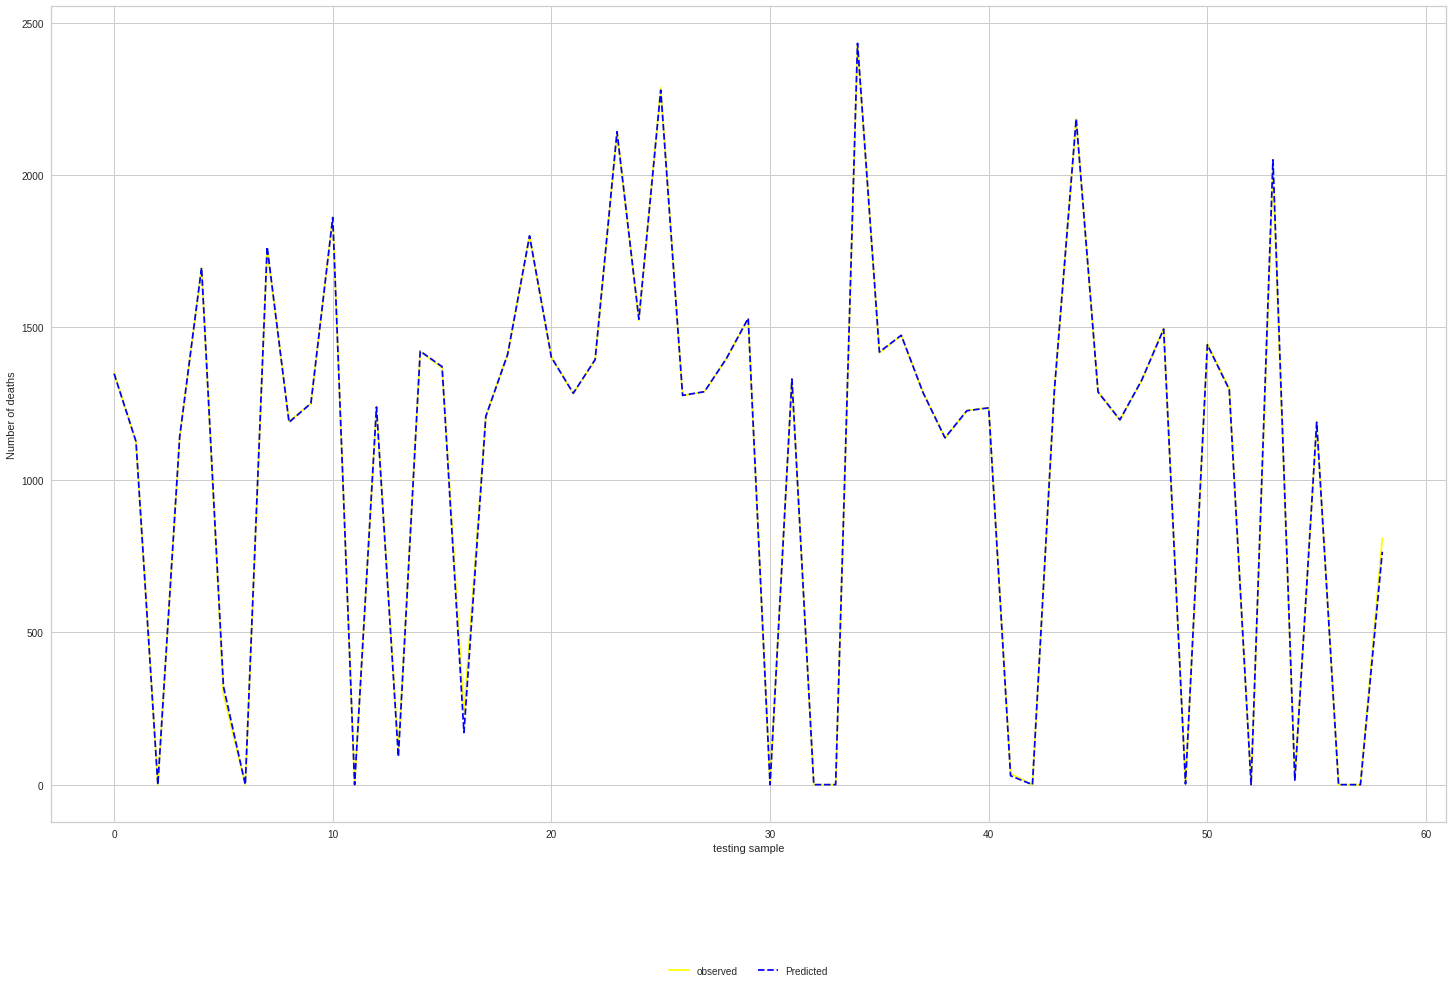

In [151]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
x_ax=range(len(X_test))

#plot
plt.plot(x_ax,y_test, label='observed', color='yellow', linestyle='-')
plt.plot(x_ax,ytest_pred, label='Predicted',color='blue',linestyle='--')
plt.ylabel('Number of deaths')
plt.xlabel('testing sample')
plt.legend(bbox_to_anchor = (0.5, -0.2), loc = 'lower center', ncol=2, frameon = False)


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


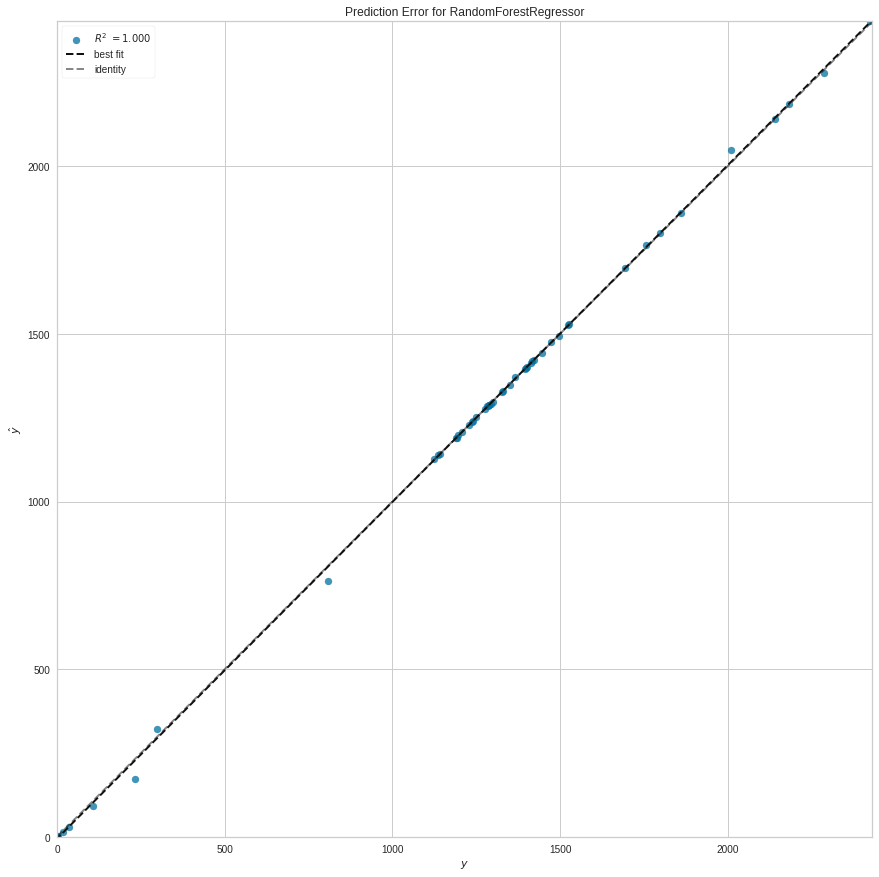

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [160]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(fit_model)
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


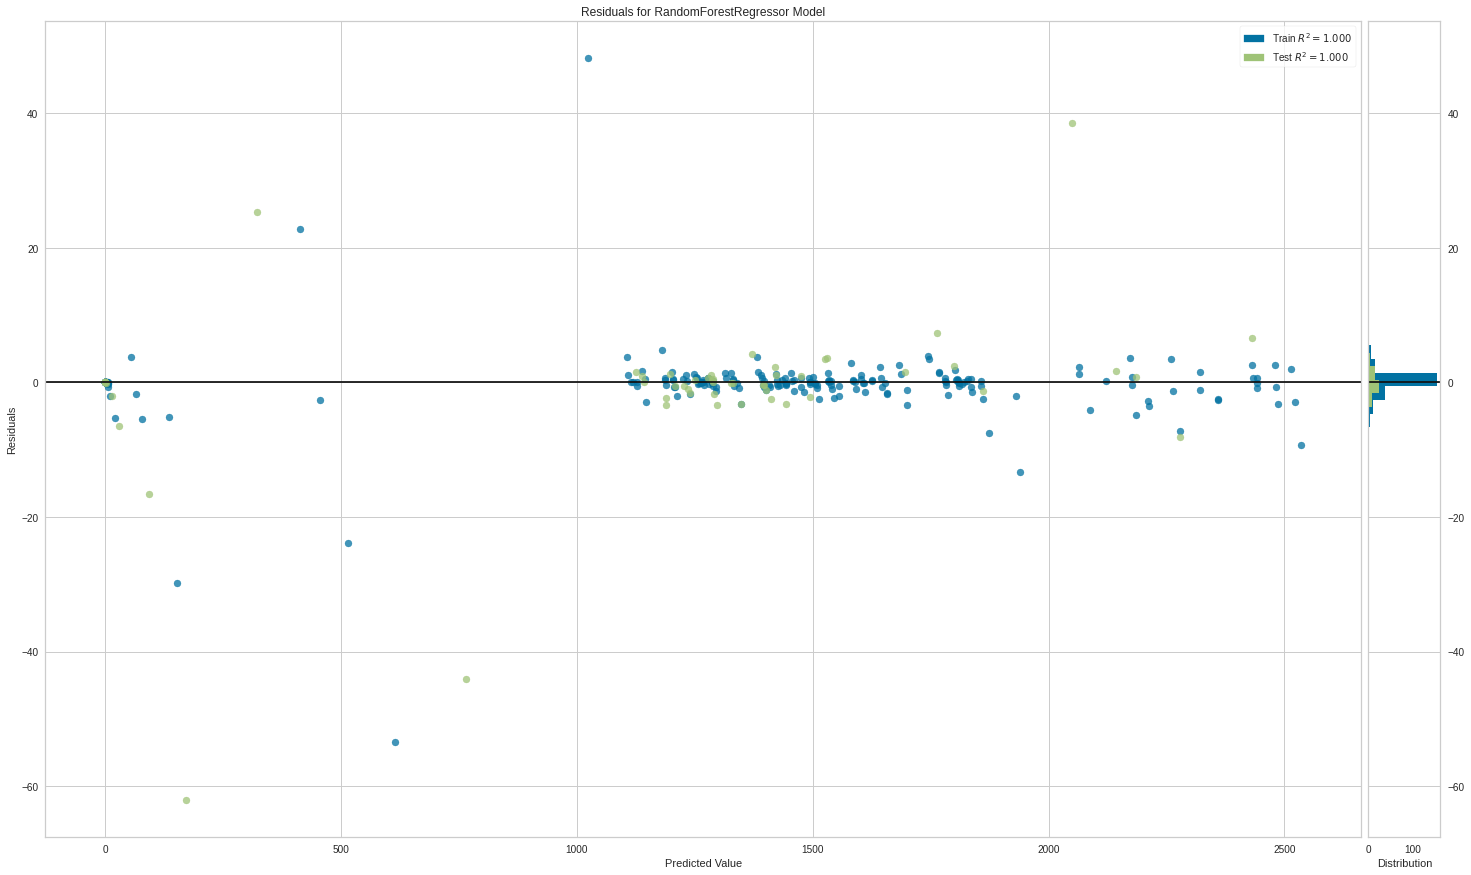

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [161]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(fit_model)
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof()

In [162]:
from sklearn.model_selection import cross_val_score
seed = 7
score_train = cross_val_score(fit_model,X_train,y_train,scoring='neg_mean_squared_error', cv =10)
score_train

array([  -16.38693635,  -811.62690567,    -7.51560834,  -129.21565313,
         -15.1648971 ,  -199.26488922,   -21.50483806, -1546.84804513,
         -36.11095485,   -15.23252907])

In [163]:
print(np.mean(score_train))

-279.88712569311144


In [164]:
from numpy import absolute
print(absolute(np.mean(score_train)))

279.88712569311144


In [165]:
score_test = cross_val_score(fit_model,X_test, y_test, scoring ="neg_mean_absolute_error", cv=10)
score_test 

array([-39.65759167,  -5.62147667, -24.09500333,  -5.359415  ,
       -25.74472833, -31.52227167,  -9.01038333,  -3.11375833,
       -14.5375    , -69.256836  ])

In [166]:
print(absolute(np.mean(score_test)))

22.79189643333331


In [167]:
#!pip install --upgrade scikit-learn
from sklearn.pipeline import Pipeline
#!pip install sklearn


f_list=list(X.columns)
f_importance = pd.Series(fit_model.feature_importances_, index=f_list).sort_values(ascending= False)
print(f_importance)

new deaths smoothed    1.0
dtype: float64
